# Simulation models (Student version)
*Written by Marc Budinger (INSA Toulouse), Scott Delbecq (ISAE-SUPAERO) and Félix Pollet (ISAE-SUPAERO), Toulouse, France.*


The objective of this notebook is to illustrate the need for implementing simulation models for design optimization. 
Simulation models enable to assess performance of a system in particular cases such as:
- operational mission profile
- specific maneuvers
- failure situations

This notebook will focus on verifiying the choice of the electrical motor for a multirotor drone application. Indeed, to main torque constraints are the maximum torque (electromagnetic technological limit) and the nominal torque (thermal technological limit).

## Mission profile

The mission profile of the UAV is the following:
1. Climb
2. Cruise
3. Loiter
4. Descent
5. Hover
6. Climb
7. Cruise
8. Descent

The parameters of the mission profile are the following:
```python


# Parameters
departure_ground_altitude = 0.0  # (m)
delivery_altitude = 100.0        # (m)
cruise_altitude = 300.0          # (m)
climb_speed = 10.0               # (m/s)
descent_speed = 5.0              # (m/s)
hover_duration = 30.0            # (s)
cruise_distance = 3000.0         # (m)
cruise_speed = 50.0              # (m/s)
loiter_duration = 120.0          # (s)
a_max = 2 * 9.81                 # (m/s²)
time_step = 1.0                  # seconds per step
```

```{exercise}
:label: exercice_mission_profile

Code the function `simulate_segment`.
```

In [1]:
import numpy as np
import pandas as pd

# Parameters
departure_ground_altitude = 0.0  # (m)
delivery_altitude = 100.0        # (m)
cruise_altitude = 300.0          # (m)
climb_speed = 10.0               # (m/s)
descent_speed = 5.0              # (m/s)
hover_duration = 30.0            # (s)
cruise_distance = 3000.0         # (m)
cruise_speed = 50.0              # (m/s)
loiter_duration = 120.0          # (s)
a_max = 2 * 9.81                 # (m/s²)
time_step = 1.0                  # seconds per step

def simulate_segment(v_init, a_init, v_target, dist, a_max, time_step):
    """
    Simulates a 1D segment with acceleration limit.
    - Start from v_init and a_init.
    - Accelerate at a_max until v_target is reached (or distance runs out).
    - Then maintain v_target until distance is covered.
    Returns arrays of time, position, speed, and acceleration.
    """

    # To be completed ...

    return np.array(times), np.array(positions), np.array(speeds), np.array(accelerations)


# 1. Climb outbound (vertical)
vert_dist_climb_out = cruise_altitude - departure_ground_altitude
t_climb_out, alt_change_out, vel_climb_out, acc_climb_out = simulate_segment(
    v_init=0.0, a_init=0.0, v_target=climb_speed, dist=vert_dist_climb_out, a_max=a_max, time_step=time_step
)
alt_climb_out = departure_ground_altitude + alt_change_out

# 2. Cruise outbound (horizontal)
t_cruise_out, dist_cruise_out, vel_cruise_out, acc_cruise_out = simulate_segment(
    v_init=vel_climb_out[-1], a_init=acc_climb_out[-1], v_target=cruise_speed, dist=cruise_distance, a_max=a_max, time_step=time_step
)
alt_cruise_out = np.full_like(t_cruise_out, cruise_altitude)

# 3. Loiter (no movement)
t_loiter = np.arange(0, loiter_duration + time_step, time_step)
alt_loiter = np.full_like(t_loiter, cruise_altitude)
dist_loiter = np.full_like(t_loiter, dist_cruise_out[-1])
vel_loiter = np.zeros_like(t_loiter)
acc_loiter = np.zeros_like(t_loiter)

# 4. Descent outbound (vertical)
vert_dist_descent_out = cruise_altitude - delivery_altitude
t_descent_out, alt_change_des_out, vel_des_out, acc_des_out = simulate_segment(
    v_init=vel_loiter[-1], a_init=acc_loiter[-1], v_target=descent_speed, dist=vert_dist_descent_out, a_max=a_max, time_step=time_step
)
alt_descent_out = cruise_altitude - alt_change_des_out
alt_descent_out[alt_descent_out < delivery_altitude] = delivery_altitude
dist_descent_out = np.full_like(t_descent_out, dist_loiter[-1])

# 5. Hover outbound at delivery altitude (no movement)
t_hover_out = np.arange(0, hover_duration + time_step, time_step)
alt_hover_out = np.full_like(t_hover_out, delivery_altitude)
dist_hover_out = np.full_like(t_hover_out, dist_descent_out[-1])
vel_hover_out = np.zeros_like(t_hover_out)
acc_hover_out = np.zeros_like(t_hover_out)

# 6. Climb inbound (vertical)
vert_dist_climb_in = cruise_altitude - delivery_altitude
t_climb_in, alt_change_climb_in, vel_climb_in, acc_climb_in = simulate_segment(
    v_init=vel_hover_out[-1], a_init=acc_hover_out[-1], v_target=climb_speed, dist=vert_dist_climb_in, a_max=a_max, time_step=time_step
)
alt_climb_in = delivery_altitude + alt_change_climb_in
alt_climb_in[alt_climb_in > cruise_altitude] = cruise_altitude
dist_climb_in = np.full_like(t_climb_in, dist_hover_out[-1])

# 7. Cruise inbound (horizontal)
t_cruise_in, dist_cruise_in_val, vel_cruise_in, acc_cruise_in = simulate_segment(
    v_init=vel_climb_in[-1], a_init=acc_climb_in[-1], v_target=cruise_speed, dist=cruise_distance, a_max=a_max, time_step=time_step
)
alt_cruise_in = np.full_like(t_cruise_in, cruise_altitude)
dist_cruise_in = dist_climb_in[-1] + dist_cruise_in_val

# 8. Descent inbound (vertical)
vert_dist_descent_in = cruise_altitude - departure_ground_altitude
t_descent_in, alt_change_des_in, vel_des_in, acc_des_in = simulate_segment(
    v_init=vel_cruise_in[-1], a_init=acc_cruise_in[-1], v_target=descent_speed, dist=vert_dist_descent_in, a_max=a_max, time_step=time_step
)
alt_descent_in = cruise_altitude - alt_change_des_in
alt_descent_in[alt_descent_in < departure_ground_altitude] = departure_ground_altitude
dist_descent_in = np.full_like(t_descent_in, dist_cruise_in[-1])

# Time offsets
t0_climb_out = 0.0
t0_cruise_out = t0_climb_out + t_climb_out[-1]
t0_loiter = t0_cruise_out + t_cruise_out[-1]
t0_descent_out = t0_loiter + t_loiter[-1]
t0_hover_out = t0_descent_out + t_descent_out[-1]
t0_climb_in = t0_hover_out + t_hover_out[-1]
t0_cruise_in = t0_climb_in + t_climb_in[-1]
t0_descent_in = t0_cruise_in + t_cruise_in[-1]

time_climb_out_abs = t0_climb_out + t_climb_out
time_cruise_out_abs = t0_cruise_out + t_cruise_out
time_loiter_abs = t0_loiter + t_loiter
time_descent_out_abs = t0_descent_out + t_descent_out
time_hover_out_abs = t0_hover_out + t_hover_out
time_climb_in_abs = t0_climb_in + t_climb_in
time_cruise_in_abs = t0_cruise_in + t_cruise_in
time_descent_in_abs = t0_descent_in + t_descent_in

segment_climb_out = np.full_like(time_climb_out_abs, "Climb outbound", dtype=object)
segment_cruise_out = np.full_like(time_cruise_out_abs, "Cruise outbound", dtype=object)
segment_loiter = np.full_like(time_loiter_abs, "Loiter", dtype=object)
segment_descent_out = np.full_like(time_descent_out_abs, "Descent outbound", dtype=object)
segment_hover_out = np.full_like(time_hover_out_abs, "Hover outbound", dtype=object)
segment_climb_in = np.full_like(time_climb_in_abs, "Climb inbound", dtype=object)
segment_cruise_in = np.full_like(time_cruise_in_abs, "Cruise inbound", dtype=object)
segment_descent_in = np.full_like(time_descent_in_abs, "Descent inbound", dtype=object)

time_all = np.concatenate([
    time_climb_out_abs,
    time_cruise_out_abs,
    time_loiter_abs,
    time_descent_out_abs,
    time_hover_out_abs,
    time_climb_in_abs,
    time_cruise_in_abs,
    time_descent_in_abs
])

alt_all = np.concatenate([
    alt_climb_out,
    alt_cruise_out,
    alt_loiter,
    alt_descent_out,
    alt_hover_out,
    alt_climb_in,
    alt_cruise_in,
    alt_descent_in
])

dist_all = np.concatenate([
    np.zeros_like(t_climb_out),  # no horizontal move in climb_out
    dist_cruise_out,
    dist_loiter,
    dist_descent_out,
    dist_hover_out,
    dist_climb_in,
    dist_cruise_in,
    dist_descent_in
])

speed_all = np.concatenate([
    vel_climb_out,
    vel_cruise_out,
    vel_loiter,
    vel_des_out,
    vel_hover_out,
    vel_climb_in,
    vel_cruise_in,
    vel_des_in
])

acc_all = np.concatenate([
    acc_climb_out,
    acc_cruise_out,
    acc_loiter,
    acc_des_out,
    acc_hover_out,
    acc_climb_in,
    acc_cruise_in,
    acc_des_in
])

segment_all = np.concatenate([
    segment_climb_out,
    segment_cruise_out,
    segment_loiter,
    segment_descent_out,
    segment_hover_out,
    segment_climb_in,
    segment_cruise_in,
    segment_descent_in
])

df = pd.DataFrame({
    "time": time_all,
    "altitude": alt_all,
    "horizontal_distance": dist_all,
    "speed": speed_all,
    "acceleration": acc_all,
    "segment": segment_all
})

df = df.sort_values("time").reset_index(drop=True)
df 

,time,altitude,horizontal_distance,speed,acceleration,segment
0,0.0,0.0,0.0,0.0,0.00,Climb outbound
1,1.0,5.0,0.0,10.0,19.62,Climb outbound
2,2.0,15.0,0.0,10.0,0.00,Climb outbound
3,3.0,25.0,0.0,10.0,0.00,Climb outbound
4,4.0,35.0,0.0,10.0,0.00,Climb outbound
...,...,...,...,...,...,...
424,417.0,17.5,6000.0,5.0,0.00,Descent inbound
425,418.0,12.5,6000.0,5.0,0.00,Descent inbound
426,419.0,7.5,6000.0,5.0,0.00,Descent inbound
427,420.0,2.5,6000.0,5.0,0.00,Descent inbound


Lets now plot the resulting mission profile to verify its consistency.

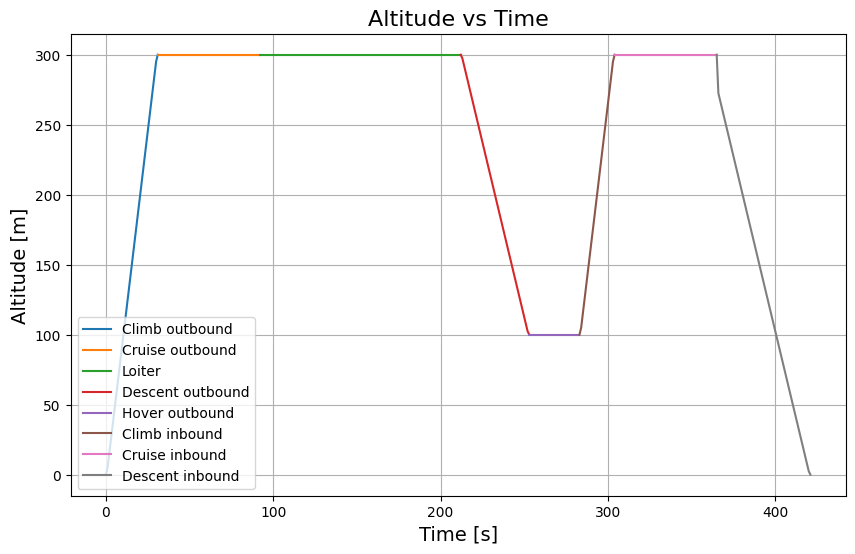

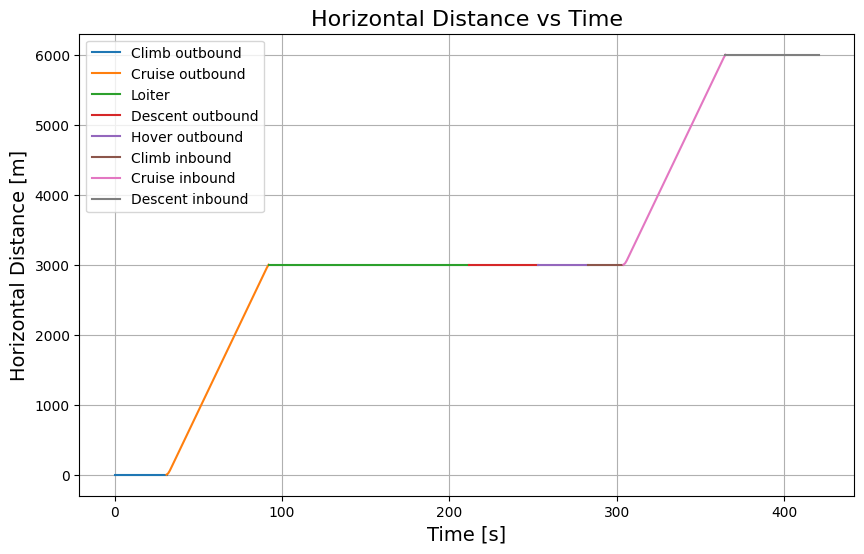

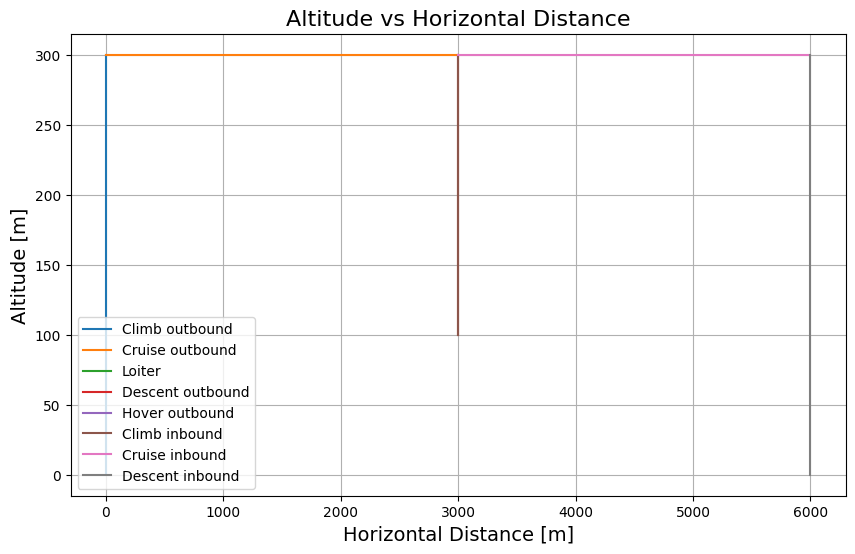

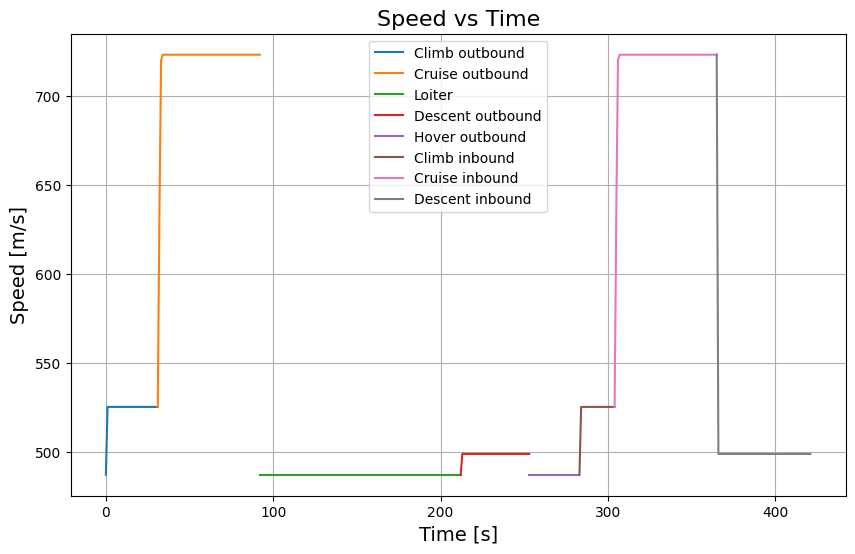

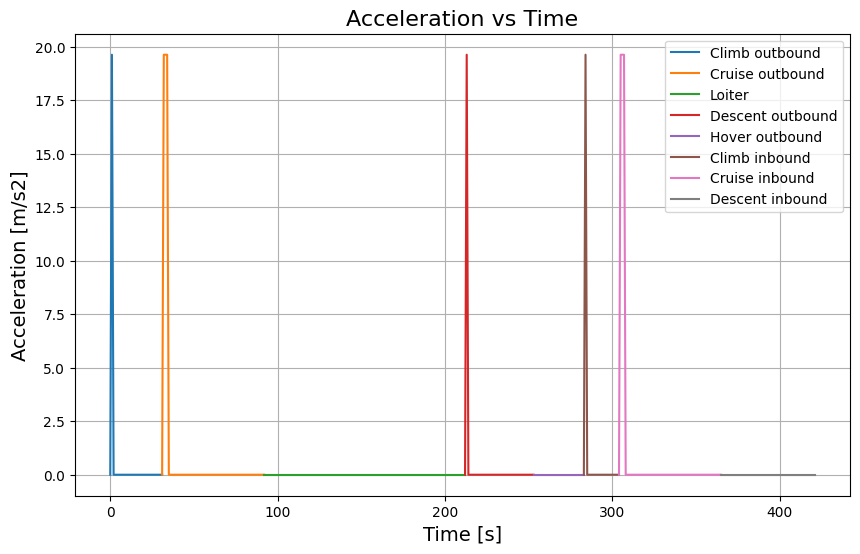

In [14]:
import matplotlib.pyplot as plt

# Plot altitude vs time
plt.figure(figsize=(10,6))
segments = df['segment'].unique()
for seg in segments:
    seg_data = df[df['segment'] == seg]
    plt.plot(seg_data['time'], seg_data['altitude'], label=seg)

plt.title("Altitude vs Time", fontsize=16)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Altitude [m]", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot horizontal distance vs time
plt.figure(figsize=(10,6))
segments = df['segment'].unique()
for seg in segments:
    seg_data = df[df['segment'] == seg]
    plt.plot(seg_data['time'], seg_data['horizontal_distance'], label=seg)
    
plt.title("Horizontal Distance vs Time", fontsize=16)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Horizontal Distance [m]", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


# Plot speed vs time
plt.figure(figsize=(10,6))
segments = df['segment'].unique()
for seg in segments:
    seg_data = df[df['segment'] == seg]
    plt.plot(seg_data['horizontal_distance'], seg_data['altitude'], label=seg)
    
plt.title("Altitude vs Horizontal Distance", fontsize=16)
plt.xlabel("Horizontal Distance [m]", fontsize=14)
plt.ylabel("Altitude [m]", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot speed vs time
plt.figure(figsize=(10,6))
segments = df['segment'].unique()
for seg in segments:
    seg_data = df[df['segment'] == seg]
    plt.plot(seg_data['time'], seg_data['speed'], label=seg)
    
plt.title("Speed vs Time", fontsize=16)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Speed [m/s]", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot acceleration vs time
plt.figure(figsize=(10,6))
segments = df['segment'].unique()
for seg in segments:
    seg_data = df[df['segment'] == seg]
    plt.plot(seg_data['time'], seg_data['acceleration'], label=seg)
    
plt.title("Acceleration vs Time", fontsize=16)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Acceleration [m/s2]", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## Parameters of the system

To simulate the propeller torque we have to consider several parameters for the system and the components.

### UAV
```python
M_total = 1.35  # [kg] mass of the drone
```

### Propeller
```python
D_pro = 10 * 0.0254  # [m] Propeller diameter
N_pro = 4 # [-] Number of propellers

# APC coefficients
# Ct=T/(rho * n**2 * D**4) (thrust coef.)
Ct = 0.1125  # [-] Thrust coefficient, propeller notation
# Cp=P/(rho * n**3 * D**5) (power coef.)
Cp = 0.0441  # [-] Power coefficient, propeller notation
```

### Aerodynamics
```python
# Aerodynamics
rho = 1.18  # [kg/m^3] Air mass volumic (25°C)
CD_frame = 0.5  # [-] Frame drag coefficient
S_frame = 0.1  # [m^2] Frame surface
CD_pro = 0.015  # [-] Propeller drag coefficient
```

In [3]:
# UAV
M_total = 1.35  # [kg] mass of the drone

# Propeller
D_pro = 10 * 0.0254  # [m] Propeller diameter
N_pro = 4 # [-] Number of propellers

# APC coefficients
# Ct=T/(rho * n**2 * D**4) (thrust coef.)
Ct = 0.1125  # [-] Thrust coefficient, propeller notation
# Cp=P/(rho * n**3 * D**5) (power coef.)
Cp = 0.0441  # [-] Power coefficient, propeller notation

# Aerodynamics
rho = 1.18  # [kg/m^3] Air mass volumic (25°C)
CD_frame = 0.5  # [-] Frame drag coefficient
S_frame = 0.1  # [m^2] Frame surface
CD_pro = 0.015  # [-] Propeller drag coefficient

## Verification of the thermal behaviour with the RMS torque

```{exercise}
:label: exercice_thrust_profile

Determine the thrust, torque, speed and power of the propeller with respect to time.
```

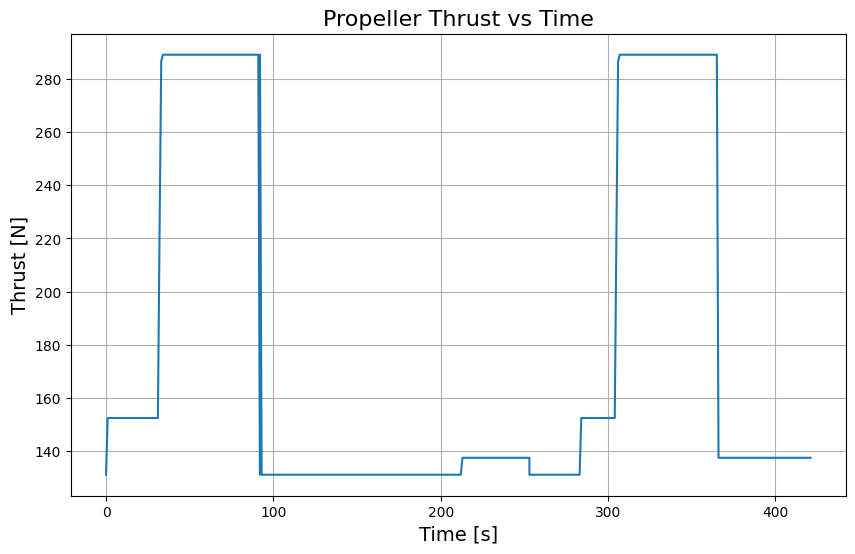

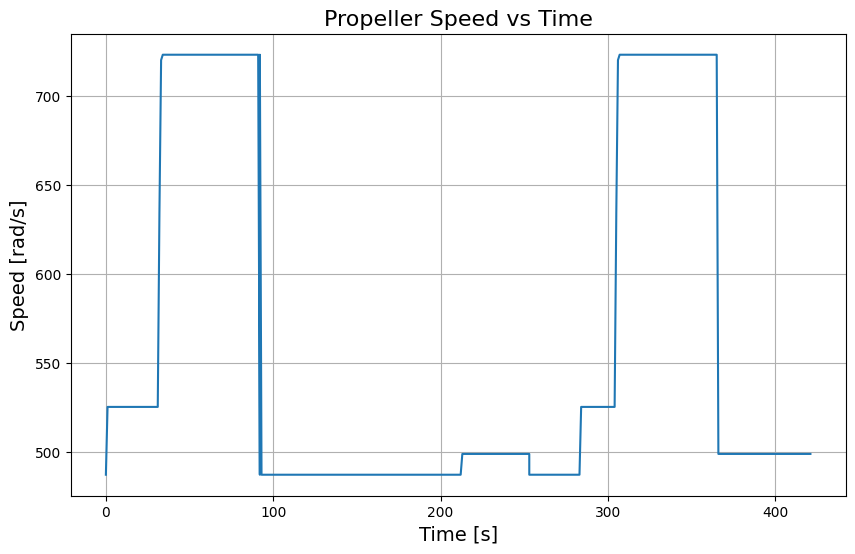

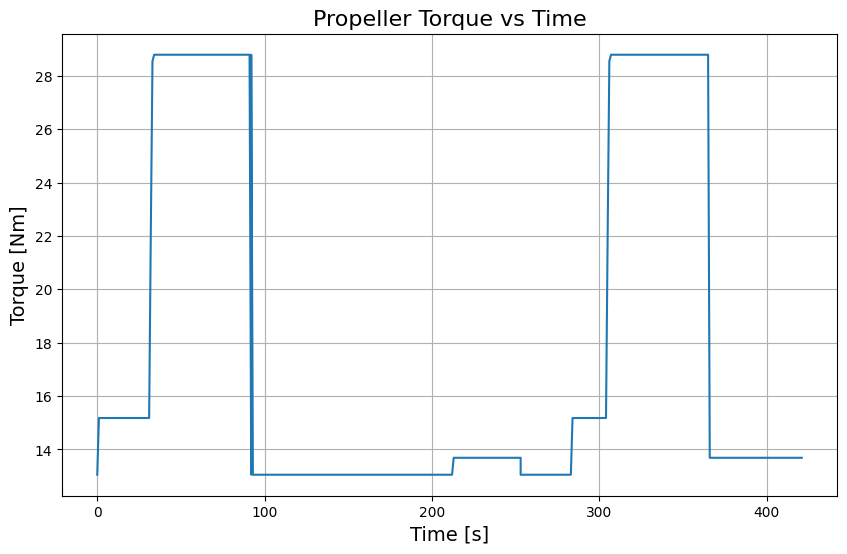

In [12]:
# Compute propeller thrust and speed for each segment
thrust = np.zeros_like(df['time'])
speed = np.zeros_like(df['time'])
torque= np.zeros_like(df['time'])
power = np.zeros_like(df['time'])

# To be completed ...
        
df['thrust'] = thrust
df['speed'] = speed
df['torque'] = torque
df['power'] = power

# Plot thrust vs time
plt.figure(figsize=(10,6))
plt.plot(df['time'], df['thrust'])
plt.title("Propeller Thrust vs Time", fontsize=16)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Thrust [N]", fontsize=14)
plt.grid(True)
plt.show()

# Plot speed vs time
plt.figure(figsize=(10,6))
plt.plot(df['time'], df['speed'])
plt.title("Propeller Speed vs Time", fontsize=16)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Speed [rad/s]", fontsize=14)
plt.grid(True)
plt.show()

# Plot torque vs time
plt.figure(figsize=(10,6))
plt.plot(df['time'], df['torque'])
plt.title("Propeller Torque vs Time", fontsize=16)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Torque [Nm]", fontsize=14)
plt.grid(True)
plt.show()

```{exercise}
:label: exercice_thrust_profile

Compute the RMS torque and maximum torque of the propeller and select an appropriate motor in the AXI motor catalogue.
```

In [13]:
# Compute RMS torque
rms_torque =

# Compute max torque
max_torque =

print(f"Max torque of {max_torque} [Nm] and RMS torque of {rms_torque} [Nm] ")

Max torque of 28.79192551064113 [Nm] and RMS torque of 19.20764863002925 [Nm] 


In [16]:
# Pandas package Importation
import pandas as pd

# Read the .csv file with bearing data
path = "https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-multirotor/assets/data/"
df = pd.read_excel(path + "AXI_mot_db_student.xlsx", engine="openpyxl")
# Print the head (first lines of the file)
df.head()

,Name,Kv (rpm/v),Pole (number),Io (A),r (omn),weight (g),Imax (A),No s,Voltage,Inom_max (A),Eta_max (%),Kt (N.m/A),Tnom (N.m)
0,AXI 2203/40VPP GOLD LINE,2000,14,0.50,0.245,17.5,9.0,2,7.4,7.5,75,0.004775,0.033423
1,AXI 2203/46 GOLD LINE,1720,14,0.50,0.285,18.5,8.5,2,7.4,7.0,75,0.005552,0.036087
2,AXI 2203/52 GOLD LINE,1525,14,0.40,0.390,18.5,7.0,2,7.4,5.5,74,0.006262,0.031935
3,AXI 2203/RACE GOLD LINE,2300,14,0.55,0.220,18.5,9.0,3,11.1,7.5,74,0.004152,0.028855
4,AXI 2204/54 GOLD LINE,1400,14,0.35,0.320,25.9,7.5,3,11.1,6.0,77,0.006821,0.038538


## Verification of the thermal behaviour with the a first order thermal model (Bonus)

